# Imports and Data loading

In [92]:
######### List of imports ################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
import pmdarima as pm
from ThymeBoost import ThymeBoost as tb
import math
import sklearn.metrics as metrics
from scipy.stats import norm
###########################################

In [2]:
## Read data from "BTCUSD"
## csv here should be updated for new use

data = pd.read_csv("/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data0329.csv")

# Feature Creation

In [3]:
data.head()

,bp_1,bz_1,bp_2,bz_2,bp_3,bz_3,bp_4,bz_4,bp_5,bz_5,...,ap_17,az_17,ap_18,az_18,ap_19,az_19,ap_20,az_20,scrape_time,lastUpdateId
0,27215.98,3.62823,27215.71,0.09094,27215.15,0.06106,27215.14,0.10176,27213.06,0.11000,...,27220.22,0.18378,27220.24,0.18378,27220.40,0.38577,27220.87,0.73017,2023-03-28 19:33:30,17688482161
1,27219.01,2.49441,27218.96,0.40455,27218.95,0.81592,27218.94,0.56887,27218.86,0.51754,...,27221.64,0.05013,27221.79,0.03673,27222.27,0.04246,27222.44,0.03673,2023-03-28 19:33:24,17688480766
2,27219.01,0.53591,27218.72,0.41551,27218.71,0.07000,27218.40,0.00671,27218.36,0.57475,...,27223.09,0.22057,27223.10,0.36755,27223.24,0.46670,27223.25,0.00367,2023-03-28 19:33:19,17688480114
3,27223.23,6.40427,27221.59,1.00260,27221.39,0.03674,27221.36,1.10536,27221.34,1.10536,...,27227.34,0.18374,27227.92,1.06032,27228.39,1.21947,27228.40,2.03245,2023-03-28 19:33:36,17688483548
4,27223.23,0.48052,27222.67,0.48829,27222.40,0.09468,27222.29,0.57712,27222.22,0.00921,...,27227.34,0.36748,27228.05,0.03622,27228.07,1.01425,27228.08,0.78360,2023-03-28 19:33:07,17688478201


In [4]:
# Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

In [5]:
## Log price

def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

data['log_returns'] = data.log_price.diff()

In [6]:
## Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

In [7]:
## Previous volatility

data['volatility_t+1'] = data['realized_volatility'].shift(-1)

In [8]:
y = data['realized_volatility'].to_frame()

In [10]:
## Create a copy of data named df
df = data

In [11]:
## Drop the target y
df.drop(['realized_volatility'], axis = 1, inplace = True) 

In [12]:
## Check if two roles have the same value
df.duplicated().value_counts()

False    2644
dtype: int64

# Deal with Missing Data

💡 NOTE: 

Be aware of the **fill_value** in imputer2, we want to use the next log return to fill the empty data missing in the first row.

Therefore, the df.iloc[value] can vary based on scenarios.

In [22]:
## Imputer work on df['volatility_t+1']

imputer = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer.fit(df[['volatility_t+1']]) # Call the "fit" method on the object

df['volatility_t+1'] = imputer.transform(df[['volatility_t+1']]) # Call the "transform" method on the object

imputer.statistics_ # The mean is stored in the transformer's memory

array([0.])

In [21]:
## Imputer2 work on df['log_returns']

imputer2 = SimpleImputer(strategy="constant", fill_value = df.iloc[1,84])

imputer2.fit(df[['log_returns']]) # Call the "fit" method on the object

df['log_returns'] = imputer2.transform(df[['log_returns']]) # Call the "transform" method on the object

imputer2.statistics_ # The mean is stored in the transformer's memory

array([0.00011149])

In [23]:
## Imputer3 work on y['realized_volatility']

imputer3 = SimpleImputer(strategy="constant", fill_value = 0) # Instantiate a SimpleImputer object with your strategy of choice

imputer3.fit(y[['realized_volatility']]) # Call the "fit" method on the object

y['realized_volatility'] = imputer3.transform(y[['realized_volatility']]) # Call the "transform" method on the object

imputer3.statistics_ # The mean is stored in the transformer's memory

array([0.])

# Boosted-Linear Auto-ARIMA (mape:0.0396) 

💡 NOTE:

The separator should be define based on the length of the obtained data. Making sure 65% being used as the train and 35% used as the test.

In [32]:
## round up the 65% number into int

separator = math.ceil(len(y)*0.65)

In [34]:
train = y[0:separator]['realized_volatility']
test = y[separator:]['realized_volatility']

In [119]:
boosted_model = tb.ThymeBoost(verbose=1)
output = boosted_model.fit(train,
                            trend_estimator=['linear', 'arima'],
                            arima_order='auto',
                            global_cost='mse')

********** Round 1 **********
Using Split: None
Fitting initial trend globally with trend model:
median()
seasonal model:
None
cost: 1.70938144223145e-07
********** Round 2 **********
Using Split: None
Fitting global with trend model:
linear((1, None))
seasonal model:
None
cost: 1.7075526299601778e-07
********** Round 3 **********
Using Split: None
Fitting global with trend model:
arima(auto)
seasonal model:
None
cost: 2.0982679398210696e-09
Boosting Terminated 
Using round 3


In [120]:
predicted_output = boosted_model.predict(output, len(test))

# Output Specificity 

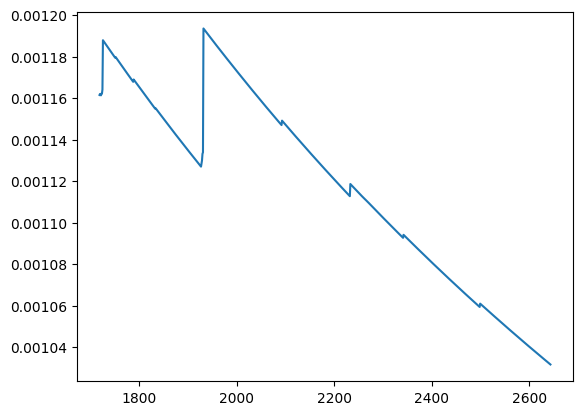

In [121]:
plt.plot(test)

In [122]:
predicted_output['predictions']

1719    0.001152
1720    0.001152
1721    0.001152
1722    0.001152
1723    0.001152
          ...   
2639    0.001140
2640    0.001140
2641    0.001140
2642    0.001140
2643    0.001140
Name: predictions, Length: 925, dtype: float64

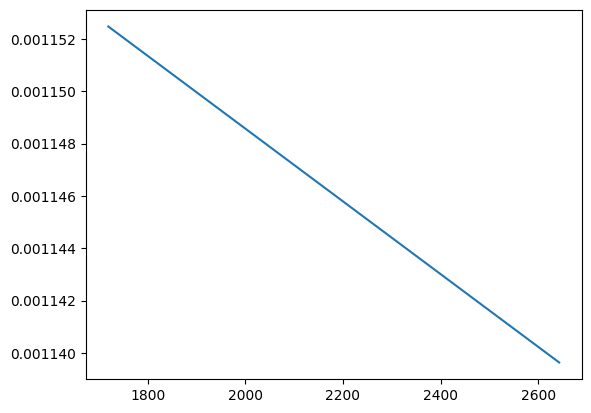

In [123]:
plt.plot(predicted_output['predictions'])

In [61]:
y_pred = predicted_output['predictions']

⬇️  Specify the token name and the number of secs in the future you would like to know

In [83]:
token = "BTCUSD"
sequence = [5, 30, 300, 600, 1800] # Translate into 5 secs, 30 secs, 5 minutes, 10 minutes, and 30 minutes

In [87]:
print("Below is an output summary:")
print("")

for i in sequence:
    index = int((int(i)/5) - 1)
    result_pred = round(y_pred.iloc[index],6)
    if i > 60:
        i = int(i/60)
        print(f"The volatility for {token} in the next {i} minutes is {result_pred}")
    else:
        print(f"The volatility for {token} in the next {i} secs is {result_pred}")

Below is an output summary:

The volatility for BTCUSD in the next 5 secs is 0.001152
The volatility for BTCUSD in the next 30 secs is 0.001152
The volatility for BTCUSD in the next 5 minutes is 0.001152
The volatility for BTCUSD in the next 10 minutes is 0.001151
The volatility for BTCUSD in the next 30 minutes is 0.001147


# Model Testing

In [37]:
tb_mae = np.mean(np.abs(test - predicted_output['predictions']))
tb_rmse = (np.mean((test - predicted_output['predictions'])**2))**.5
tb_mape = np.sum(np.abs(predicted_output['predictions'] - test)) / (np.sum((np.abs(test))))

tb_mape, tb_mae, tb_rmse

(0.03593402097079403, 4.017894203928054e-05, 5.080574660635808e-05)

In [ ]:
y_pred = predicted_output['predictions']

In [59]:
test - y_pred

1719    0.000009
1720    0.000010
1721    0.000009
1722    0.000009
1723    0.000010
          ...   
2639   -0.000107
2640   -0.000107
2641   -0.000107
2642   -0.000108
2643   -0.000108
Length: 925, dtype: float64

# Gussian Mixture Model

Gussian Mixture Model Explained: https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95

Implementation: https://medium.com/swlh/gaussian-mixture-models-gmm-1327a2a62a

In [88]:
y_pred.shape

(925,)

In [93]:
class GMM1D:
    """Apply GMM to 1D Data"""
    
    def __init__(self, X, max_iterations):
        """Initialize data and max_iterations"""
        self.X = X
        self.max_iterations = max_iterations
        
    def run(self):
        """Initialize parameters mu, var, pi"""
        self.pi = np.array([1/3, 1/3, 1/3])
        self.mu = np.array([5,8,1])
        self.var = np.array([5,3,1])
        
        r = np.zeros((len(self.X), 3))
        
        for itr in range(self.max_iterations):
    
            gauss1 = norm(loc=self.mu[0], scale=self.var[0])
            gauss2 = norm(loc=self.mu[1], scale=self.var[1])
            gauss3 = norm(loc=self.mu[2], scale=self.var[2])
            
            # E-Step
            for c,g,p in zip(range(3), [gauss1, gauss2, gauss3], self.pi):
                r[:,c] = p*g.pdf(xt[:])

            for i in range(len(r)):
                r[i,:] /= np.sum(r[i,:])

            fig = plt.figure(figsize=(10,10))
            ax0 = fig.add_subplot(111)

            for i in range(len(r)):
                ax0.scatter(xt[i],0,c=r[i,:],s=100) 

            for g,c in zip([gauss1.pdf(np.linspace(-15,15)),gauss2.pdf(np.linspace(-15,15)),gauss3.pdf(np.linspace(-15,15))],['r','g','b']):
                ax0.plot(np.linspace(-15,15),g,c=c,zorder=0)

            plt.show()

            # M-Step
            mc = np.sum(r, axis=0)
            self.pi = mc/len(self.X)
            self.mu = np.sum(r*np.vstack((self.X, self.X, self.X)).T, axis=0)/mc
            self.var = []

            for c in range(len(self.pi)):
                self.var.append(np.sum(np.dot(r[:,c]*(self.X[i] - self.mu[c]).T, r[:,c]*(self.X[i] - self.mu[c])))/mc[c])

gmm = GMM1D(y_pred, 10)
gmm.run()

NameError: name 'xt' is not defined